In [ ]:
# import sys
# # !{sys.executable} -m pip install lightgbm
# !{sys.executable} -m pip install libomp

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# sklearn tools for model training and assesment

from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import (roc_curve, auc, accuracy_score)

In [2]:
print('Loading data...')
data_path = './input/'
df = pd.read_csv(data_path + 'train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
songs = pd.read_csv(data_path + 'songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv(data_path + 'members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'})
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')

Loading data...


In [3]:
print('Data preprocessing...')
song_cols = ['song_id', 'artist_name', 'genre_ids', 'song_length', 'language']
df = df.merge(songs[song_cols], on='song_id', how='left')

Data preprocessing...


In [4]:
members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
members['registration_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
members['registration_date'] = members['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
members['expiration_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
members['expiration_date'] = members['expiration_date'].apply(lambda x: int(str(x)[6:8]))
members = members.drop(['registration_init_time'], axis=1)

In [5]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)
df = df.merge(members, on='msno', how='left')
df = df.merge(songs_extra, on = 'song_id', how = 'left')

In [6]:
len(df)

7377418

In [7]:
import gc
del members, songs; gc.collect();

for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].astype('category')

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [9]:
X = train.drop(['target'], axis=1)
y = train['target'].values

X_test = test.drop(['target'], axis=1)
y_test = test['target'].values


del train, test; gc.collect();

d_train = lgb.Dataset(X, y)
d_test = lgb.Dataset(X_test, y_test, reference=d_train)
# watchlist = [d_train]

In [13]:
# default model
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['binary_logloss','auc'],
    'is_training_metric': True,
    'tree_learner': 'serial',
}

In [11]:
# train
# gbm = lgb.train(params,
#                 d_train,
#                 valid_sets=d_test,
#                 num_boost_round = 200,
#                verbose_eval = 10)

In [14]:
# grid search the best parameters
gridParams = {
    'learning_rate': [0.1,0.5],
    'min_data_in_leaf': [100,500],
    'max_depth': [5,10],
    'subsample':[0.5,1],
    'reg_alpha':[0,0.1]
}

mdl = lgb.LGBMClassifier(
    task = params['task'],
    metric = params['metric'],
    is_training_metric = params['is_training_metric'],
    tree_learner = params['tree_learner'],
    n_jobs = -1
)

scoring = {'AUC': 'roc_auc'}

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=3, scoring=scoring,n_jobs=-1,refit='AUC')
# Run the grid  
grid.fit(X, y)

print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 104.0min finished


Best parameters found by grid search are: {'learning_rate': 0.5, 'max_depth': 10, 'min_data_in_leaf': 100, 'reg_alpha': 0, 'subsample': 0.5}
Best score found by grid search is: 0.7758428510586608


In [ ]:
grid.grid_scores_

In [15]:
import lightgbm as lgb
params = {}
params['learning_rate'] = 0.5
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['subsample'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 100
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

In [16]:
#Prediction
y_pred=clf.predict(X_test)


In [21]:
y_pred

array([0.15104779, 0.59262517, 0.54410497, ..., 0.65235466, 0.14379059,
       0.27279174])

In [19]:
import sklearn.metrics.precision_recall_curve

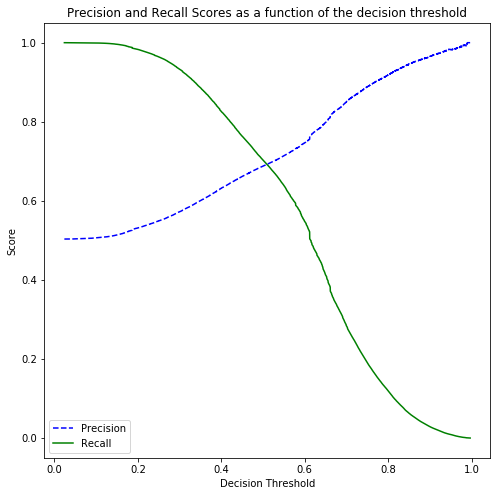

In [29]:
from matplotlib import pyplot

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
# use the same p, r, thresholds that were previously calculated

p, r, thresholds = precision_recall_curve(y_test, y_pred)
plot_precision_recall_vs_threshold(p, r, thresholds)    


In [30]:
#convert into binary values
threshold = 0.5
for i in range(0,len(y_pred)):
    if y_pred[i]>=threshold:       
        y_pred[i]=1
    else:  
        y_pred[i]=0

In [31]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,y_test)

In [32]:
cm

array([[495955, 236898],
       [220581, 522050]])

In [33]:
accuracy

0.6899464853566694